In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
from scipy import stats
import pandas as pd
import matplotlib.patches as mpatches
from scipy import stats
%matplotlib inline

In [16]:
## basic read in

In [17]:
def max_acc_point(acc_list):
    acc_point = np.argmax(acc_list)
    return acc_point

In [18]:
def min_loss_point(loss_list):
    loss_point = np.argmin(loss_list)
    return loss_point

In [19]:
def index_less_than(mylist,myvalue,value2):
    for i in range(len(mylist)):
        if mylist[i]<myvalue:
            if mylist[i]>0.78:
                return len(mylist)-1
            else:
                return i
#             if mylist[i]<value2:
#                        return i
    return len(mylist)-1

In [20]:
def es_point(acc_list,p): # p means steps after the max index
    max_num = 0
    count = 0
    for i in range(len(acc_list)):
        if acc_list[i]>max_num:
            max_num = acc_list[i]
            count = 0
        count = count+1
        if count>p:
            return i-1
    return int(len(acc_list)-1)

In [21]:
def windowed(s,half_window): # s is a list
    s_mean=[]
    s_var=[]
    window_size = half_window*2 + 1
    for i in range(len(s)-window_size+1):
        k = i + half_window 
        s_sub=s[k-half_window:k+half_window+1]
        sub_mean=sum(s_sub)/len(s_sub)
        s_mean.append(sub_mean)
        sub_var=statistics.variance(s_sub)
        s_var.append(sub_var)
    return s_mean,s_var

In [22]:
def read_acc_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean
def read_loss_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['loss'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean

In [23]:
## how to plot

In [24]:
def plot_line(i,k,basedir,result,lab,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[2][:p], label=lab[k]+addon)

In [25]:
def plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    
    (s_mean,s_varience)=windowed(s1[2][:p],half_window)

    s_epo=[i+half_window+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k]+addon,color = line_color) # can also plot s_varience if want
    
    (s_loss,_)=windowed(s1[1][:p],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    ax[i].plot(index_min_loss+half_window+1,s_mean[index_min_loss],dot_color)

#     index_max=np.argmax(s_mean)
#     ax[i].plot(index_max+half_window+1,s_mean[index_max],dot_color)


In [26]:
def plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        set_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(set_plt,normalset_mean, label=linelab+'_t')
#         print('only usual')
        
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)
        
        normal_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(normal_plt,normalset_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        delay_plt = [i+1 for i in range(len(new_delay_set))]
        ax[i].plot(delay_plt,new_delay_set, label=linelab+'_delay')

In [27]:
def plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_t')
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)

        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        (s_mean,s_varience)=windowed(new_delay_set,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_delay')


## Bad Node

In [62]:
half_window = 10
th = 0.025
value2 = 1

index_min_loss_list = []
index_min_acc_list = []
min_loss_list = []
min_acc_list = []
acc_at_min_loss_list = []
index_less_than_nb_list = []
gap_to_min_list = []
acc_drop_list = []


basedir=os.path.join('RESULT_4000/BadNode')

color_list=[
#     'k',
    'r','c',
#     'k',
    'r','c',
#     'k',
    'r','c',
    
#     'k',
    'r','b','c',
#     'k',
#     'r','b','c',
#     'k',
    'r','b','c',
#     'k',
    'r','b','c',
    
]

size_list = [
    1,1,1,1,1,1,
    2,2,2,2,2,2,2,2,2,
]
iid_list = [
    1,1,2,2,3,3,
    1,1,1,2,2,2,3,3,3,
]


result=[
#     '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
    '2c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-015142.npy',
    '2c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-031558.npy',

#     '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
    '5c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-023155.npy',
    '5c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-004052.npy',

#     'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
    '11d.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-020918.npy',
    '11d.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-060927.npy',
]

for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    index_min_acc = min_loss_point(s_acc[index_min_loss:])+index_min_loss
    
    
    min_loss = s_loss[index_min_loss]
    min_acc = s_acc[index_min_acc]
    
    acc_at_min_loss = s_acc[index_min_loss]
    index_less_than_nb = index_less_than(s_acc[index_min_loss:],min_acc+th,value2)+index_min_loss #index of acc drop to min_acc+some range
    gap_to_min = index_less_than(s_acc[index_min_loss:],min_acc+th,value2) #gap between cropped & min_loss
    
    acc_drop = s_acc[index_less_than_nb]
    
    
    index_min_loss_list.append(index_min_loss)
    index_min_acc_list.append(index_min_acc)
    min_loss_list.append(min_loss)
    min_acc_list.append(min_acc)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???
    index_less_than_nb_list.append(index_less_than_nb) # 
    gap_to_min_list.append(gap_to_min)
    acc_drop_list.append(acc_drop)
    
basedir=os.path.join('RESULT_40000/BadNode')    
result=[
#     '2c.10w.40000.loc1.earlystop1000.20200521-163612.npy',
    '2c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-150153.npy',
    '2c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055725.npy',
    '2c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-152141.npy',
    
# #     '3c.10w.40000.loc1.earlystop1000.20200523-042344.npy',
#     '3c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200523-043427.npy',
#     '3c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-054717.npy',
#     '3c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200523-043024.npy',
    
#     '5c.10w.40000.loc1.earlystop1000.20200521-171047.npy',
    '5c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-152400.npy',
    '5c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055914.npy',
    '5c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-165039.npy',
    
#     'iid.10w.40000.loc1.earlystop1000.20200521-172951.npy',
    'iid.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-185542.npy',
    'iid.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055848.npy',
    'iid.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-152331.npy',
    

]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    index_min_acc = min_loss_point(s_acc[index_min_loss:])+index_min_loss
    
    
    min_loss = s_loss[index_min_loss]
    min_acc = s_acc[index_min_acc]
    
    acc_at_min_loss = s_acc[index_min_loss]
    index_less_than_nb = index_less_than(s_acc[index_min_loss:],min_acc+th,value2)+index_min_loss #index of acc drop to min_acc+some range
    
    gap_to_min = index_less_than(s_acc[index_min_loss:],min_acc+th,value2) #gap between cropped & min_loss
    if index_less_than_nb>=900:
        print('1')
        gap_to_min = 1100
    
    acc_drop = s_acc[index_less_than_nb]
    
    
    index_min_loss_list.append(index_min_loss)
    index_min_acc_list.append(index_min_acc)
    min_loss_list.append(min_loss)
    min_acc_list.append(min_acc)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???
    index_less_than_nb_list.append(index_less_than_nb) # 
    gap_to_min_list.append(gap_to_min)
    acc_drop_list.append(acc_drop)

1
1


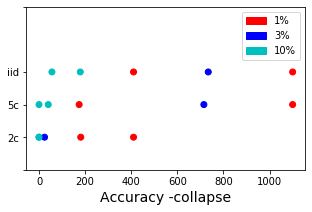

In [63]:
# plt.scatter(acc_drop_list,size_list,color=color_list) # index_less_than_nb_list    acc_drop_list  
# plt.xlabel('Global Round',fontsize=14) #Accuracy -collapse           Global Round
# plt.ylabel('Dataset Size',fontsize=14) 
# plt.yticks([0,1,2,3,4],['','4k','40k','',''],rotation=90)

plt.scatter(gap_to_min_list,iid_list,color=color_list) # gap_to_min_list    acc_drop_list 
plt.xlabel('Accuracy -collapse',fontsize=14)  #Accuracy -collapse            Global Round
# plt.ylabel('IID level',fontsize=14) 
plt.yticks([0,1,2,3,5],['','2c','5c','iid',''],rotation=0)



plt.gcf().set_size_inches(5, 3)
# black_patch = mpatches.Patch(color='k', label='0%')
red_patch = mpatches.Patch(color='r', label='1%')
b_patch = mpatches.Patch(color='b', label='3%')
c_patch = mpatches.Patch(color='c', label='10%')
plt.legend(handles=[red_patch,b_patch,c_patch])


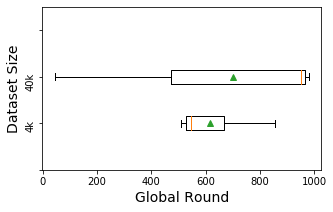

In [50]:
list1 = []
list2 = []
list3 = []


for i in range(len(size_list)): # size_list iid_list
    
    # for size_list only
    if color_list[i]=='b':
        continue
    
    if size_list[i]==1:
        list1.append(gap_to_min_list[i]) # gap_to_min_list    acc_drop_list 
    if size_list[i]==2:
        list2.append(gap_to_min_list[i]) 
    if size_list[i]==3:
        list3.append(gap_to_min_list[i]) 

plt.boxplot([list1,list2,list3],vert=False,showmeans=True)  

#####################################################################################
# plt.scatter(gap_to_min_list,size_list,color=color_list) # index_less_than_nb_list    acc_drop_list  
plt.xlabel('Global Round',fontsize=14) #Accuracy -collapse           Global Round
plt.ylabel('Dataset Size',fontsize=14) 
plt.yticks([0,1,2,3],['','4k','40k',''],rotation=90)

# # plt.scatter(gap_to_min_list,iid_list,color=color_list) # index_less_than_nb_list    acc_drop_list 
# plt.xlabel('Global Round',fontsize=14)  #Accuracy -collapse            Global Round
# # plt.ylabel('IID level',fontsize=14) 
# plt.yticks([0,1,2,3,4],['','2c','5c','iid',''],rotation=0)

####################################################################################
plt.gcf().set_size_inches(5, 3)

In [47]:
print(list1)
print(list2)
print(list3)

[412, 0, 191, 1, 413, 542]
[189, 0, 321, 43, 45, 61]
[]


In [41]:
print(stats.shapiro(list1))
print(stats.shapiro(list2))
# print(stats.shapiro(list3))

(0.7851041555404663, 0.04298820346593857)
(0.7270908355712891, 0.011778945103287697)


In [42]:
print(stats.levene(list1,list2))
# print(stats.levene(list2,list3))
# print(stats.levene(list1,list3))

LeveneResult(statistic=1.13159815149018, pvalue=0.31244705390597793)


In [43]:
print(stats.wilcoxon(list1,list2,zero_method='wilcox', correction=True))
# print(stats.wilcoxon(list2,list3,zero_method='wilcox', correction=True))
# print(stats.wilcoxon(list1,list3,zero_method='wilcox', correction=True))

WilcoxonResult(statistic=8.0, pvalue=0.6749867139704893)


c:\users\12990\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [35]:
print(stats.ttest_rel(list1, list2))
# print(stats.ttest_rel(list2, list3))
# print(stats.ttest_rel(list1, list3))

Ttest_relResult(statistic=1.1493939598239127, pvalue=0.30238645866732694)


In [36]:
# stats.f_oneway(list1,list2,list3)

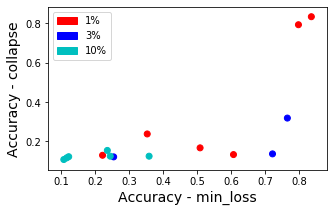

In [34]:
# plt.scatter(acc_at_min_loss_list,index_less_than_nb_list,color=color_list)
plt.scatter(acc_at_min_loss_list,acc_drop_list,color=color_list)
plt.gcf().set_size_inches(5, 3)

plt.xlabel('Accuracy - min_loss',fontsize=14)  
# plt.ylabel('Global Round',fontsize=14) 
plt.ylabel('Accuracy - collapse',fontsize=14) 

red_patch = mpatches.Patch(color='r', label='1%')
b_patch = mpatches.Patch(color='b', label='3%')
c_patch = mpatches.Patch(color='c', label='10%')
plt.legend(handles=[red_patch,b_patch,c_patch])

# plt.legend()


In [35]:
stats.pearsonr(acc_at_min_loss_list,acc_drop_list)

(0.7030488348842171, 0.003458892300080124)

In [36]:
stats.pearsonr(acc_at_min_loss_list,index_less_than_nb_list)

(0.9186475883896053, 1.3339298856627155e-06)

## Data Dispersion

In [44]:
half_window = 10

index_min_loss_list = []
min_loss_list = []
acc_at_min_loss_list = []

color_list = [
    'r','b','r','b','r','b',
    'r','b','r','b','r','b',
]


basedir=os.path.join('RESULT_4000/DataDispersion')
result=[
    '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
    '2c.40w.4000.loc1.earlystop500.20200507-172304.npy',
    '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
    '5c.40w.4000.loc1.earlystop500.20200506-215910.npy',
    'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
    'iid.40w.4000.loc1.earlystop500.20200507-014322.npy',
]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    
    min_loss = s_loss[index_min_loss]
    
    acc_at_min_loss = s_acc[index_min_loss]
    
    index_min_loss_list.append(index_min_loss)
    min_loss_list.append(min_loss)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???

basedir=os.path.join('RESULT_40000/DataDispersion')    
result=[
    '2c.10w.40000.loc1.earlystop1000.20200521-163612.npy',
    '2c.40w.40000.loc1.earlystop1000.20200522-110021.npy',
    
    '5c.10w.40000.loc1.earlystop1000.20200521-171047.npy',
    '5c.40w.40000.loc1.earlystop1000.20200522-110113.npy',
    
    'iid.10w.40000.loc1.earlystop1000.20200521-172951.npy',
    'iid.40w.40000.loc1.earlystop1000.20200522-105548.npy',
]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    
    min_loss = s_loss[index_min_loss]
    
    acc_at_min_loss = s_acc[index_min_loss]
    
    index_min_loss_list.append(index_min_loss)
    min_loss_list.append(min_loss)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???

In [47]:
mylist = [
    1,2,1,2,1,2,1,2,1,2,1,2,
]
ten_w = []
forty_w = []

for i in range(len(mylist)):
    if mylist[i]==1:
        ten_w.append(acc_at_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list
    if mylist[i]==2:
        forty_w.append(acc_at_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list
        

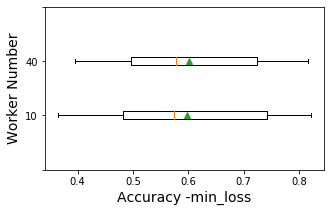

In [48]:

# plt.scatter(index_min_loss_list,mylist, color=color_list)
# plt.scatter(acc_at_min_loss_list,mylist, color=color_list)

plt.boxplot([ten_w,forty_w],vert=False,showmeans=True)  


plt.gcf().set_size_inches(5, 3)


# plt.xlabel('Global Round',fontsize=14) 
plt.xlabel('Accuracy -min_loss',fontsize=14)  
 
plt.ylabel('Worker Number',fontsize=14) 
# plt.yticks([0,1,2,4],['','10','40',''],rotation=0)
plt.yticks([0,1,2,3],['','10','40',''],rotation=0)

red_patch = mpatches.Patch(color='r', label='10w')
b_patch = mpatches.Patch(color='b', label='40w')

# plt.legend(handles=[red_patch,b_patch])

# plt.legend()

In [49]:
stats.shapiro(forty_w) # ten_w forty_w    if normal distribution both yes in this case

(0.9452585577964783, 0.7017859816551208)

In [50]:
stats.levene(ten_w, forty_w) # if p>>0.05, equal_var=true (default) 方差齐次性

LeveneResult(statistic=0.037318589000511486, pvalue=0.850685055589373)

In [51]:
stats.ttest_rel(ten_w, forty_w) #paired t test, used this!!!!

# stats.ttest_ind(ten_w, forty_w)
# stats.f_oneway(ten_w, forty_w) #ANOVA

Ttest_relResult(statistic=-0.3939412550244791, pvalue=0.7098641046040814)

## Delayed Update

In [52]:
half_window = 10

index_min_loss_list = []
min_loss_list = []
acc_at_min_loss_list = []

basedir=os.path.join('RESULT_4000/DelayUpdate')
result=[
    '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
    '2c.40w.4000.dly8.speed3.loc1.earlystop500.20200503-013135.npy',    
    '2c.40w.4000.dly20.speed3.loc1.earlystop500.20200502-160017.npy',
    '2c.40w.4000.dly32.speed3.loc1.earlystop500.20200430-223516.npy',
    '2c.40w.4000.dly8.speed12.loc1.earlystop500.20200502-161123.npy',
    '2c.40w.4000.dly8.speed30.loc1.earlystop500.20200503-084238.npy',
    
    
    '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
    '5c.40w.4000.dly8.speed3.loc1.earlystop500.20200502-160044.npy',
    '5c.40w.4000.dly20.speed3.loc1.earlystop500.20200504-180902.npy',
    '5c.40w.4000.dly32.speed3.loc1.earlystop500.20200503-210047.npy',  
    '5c.40w.4000.dly8.speed12.loc1.earlystop500.20200502-171548.npy',   
    '5c.40w.4000.dly8.speed30.loc1.earlystop500.20200502-182343.npy',


    'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
    'iid.40w.4000.dly8.speed3.loc1.earlystop500.20200502-193120.npy',
    'iid.40w.4000.dly20.speed3.loc1.earlystop500.20200503-002016.npy',
    'iid.40w.4000.dly32.speed3.loc1.earlystop500.20200502-184247.npy',
    'iid.40w.4000.dly8.speed12.loc1.earlystop500.20200502-133739.npy',
    'iid.40w.4000.dly8.speed30.loc1.earlystop500.20200503-184146.npy',
]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    
    min_loss = s_loss[index_min_loss]
    
    acc_at_min_loss = s_acc[index_min_loss]
    
    index_min_loss_list.append(index_min_loss)
    min_loss_list.append(min_loss)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???

basedir=os.path.join('RESULT_40000/DelayUpdate')    
result=[
    '2c.40w.40000.loc1.earlystop1000.20200522-110021.npy',
    '2c.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-081302.npy',
    '2c.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-010225.npy',
    '2c.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-182838.npy',    
    '2c.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-051203.npy',    
    '2c.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-050704.npy',
    
    '3c.40w.40000.loc1.earlystop1000.20200524-022211.npy',  
    '3c.40w.40000.dly10.speed3.loc1.earlystop1000.20200523-200048.npy',
    '3c.40w.40000.dly20.speed3.loc1.earlystop1000.20200523-132646.npy',
    '3c.40w.40000.dly30.speed3.loc1.earlystop1000.20200523-065723.npy',    
    '3c.40w.40000.dly10.speed15.loc1.earlystop1000.20200523-173144.npy',    
    '3c.40w.40000.dly10.speed30.loc1.earlystop1000.20200523-163044.npy',

    '5c.40w.40000.loc1.earlystop1000.20200522-110113.npy',
    '5c.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-074328.npy',
    '5c.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-010608.npy',
    '5c.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-184510.npy',  
    '5c.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-043519.npy',    
    '5c.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-053311.npy',


    'iid.40w.40000.loc1.earlystop1000.20200522-105548.npy',
    'iid.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-072117.npy',
    'iid.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-012812.npy',
    'iid.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-185705.npy',   
    'iid.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-053936.npy',    
    'iid.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-073107.npy',  
]
for res in result:
    s1 = np.load(os.path.join(basedir,res))
    (s_acc,_)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    
    min_loss = s_loss[index_min_loss]
    
    acc_at_min_loss = s_acc[index_min_loss]
    
    index_min_loss_list.append(index_min_loss)
    min_loss_list.append(min_loss)
    acc_at_min_loss_list.append(acc_at_min_loss) # Try with it's original&iid min_at_loss???

In [53]:
# color_list = [
#     'r','b','g','m','c','y',
#     'r','b','g','m','c','y',
#     'r','b','g','m','c','y',
#     'r','b','g','m','c','y',
#     'r','b','g','m','c','y',
#     'r','b','g','m','c','y',
#     'r','b','g','m','c','y',
# ]
color_list = [
    'r','r','r','r','r','r',
    'r','r','r','r','r','r',
    'r','r','r','r','r','r',
    'b','b','b','b','b','b',
    'b','b','b','b','b','b',
    'b','b','b','b','b','b',
    'b','b','b','b','b','b',
]

In [54]:
byspeed = [
    1,2,-1,-1,3,4, # 1=s0, 2=s3,3=s12,4=s30
    1,2,-1,-1,3,4,
    1,2,-1,-1,3,4,
    1,2,-1,-1,3,4,
    1,2,-1,-1,3,4,
    1,2,-1,-1,3,4,
    1,2,-1,-1,3,4,
]

In [55]:
byproportion = [
    1,2,3,4,-1,-1, #1=0, 2=20-25, 3=50,4=75-80
    1,2,3,4,-1,-1,
    1,2,3,4,-1,-1,
    1,2,3,4,-1,-1,
    1,2,3,4,-1,-1,
    1,2,3,4,-1,-1,
    1,2,3,4,-1,-1,
]

In [62]:
list1 = []
list2 = []
list3 = []
list4 = []

for i in range(len(byspeed)): # byspeed byproportion
    if byspeed[i]==1:
        list1.append(index_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list
    if byspeed[i]==2:
        list2.append(index_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list
    if byspeed[i]==3:
        list3.append(index_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list
    if byspeed[i]==4:
        list4.append(index_min_loss_list[i]) # index_min_loss_list  acc_at_min_loss_list

In [63]:
print(stats.shapiro(list1))
print(stats.shapiro(list2))
print(stats.shapiro(list3))
print(stats.shapiro(list4))

(0.9293078780174255, 0.5450283885002136)
(0.9610313773155212, 0.8275331258773804)
(0.9783974289894104, 0.951404333114624)
(0.8569827079772949, 0.14222601056098938)


In [64]:
print(stats.levene(list1,list2))
print(stats.levene(list2,list3))
print(stats.levene(list3,list4))
print(stats.levene(list1,list3))
print(stats.levene(list1,list4))

LeveneResult(statistic=0.1673410184904737, pvalue=0.6896924989488988)
LeveneResult(statistic=0.03870159442887254, pvalue=0.8473335183739926)
LeveneResult(statistic=0.7166041613262482, pvalue=0.41382339016370745)
LeveneResult(statistic=0.5106981331098461, pvalue=0.4885064641371202)
LeveneResult(statistic=1.9295664285590914, pvalue=0.19004521059887544)


In [65]:
print(stats.wilcoxon(list1,list2,zero_method='wilcox', correction=True))
print(stats.wilcoxon(list2,list3,zero_method='wilcox', correction=True))
print(stats.wilcoxon(list3,list4,zero_method='wilcox', correction=True))
print(stats.wilcoxon(list1,list3,zero_method='wilcox', correction=True))
print(stats.wilcoxon(list1,list4,zero_method='wilcox', correction=True))

WilcoxonResult(statistic=0.0, pvalue=0.022494271222449652)
WilcoxonResult(statistic=1.0, pvalue=0.03461055751570734)
WilcoxonResult(statistic=11.0, pvalue=0.6726038174415165)
WilcoxonResult(statistic=8.0, pvalue=0.35254213749971297)
WilcoxonResult(statistic=3.0, pvalue=0.07592696298255763)


In [61]:
print(stats.ttest_rel(list1, list2))
print(stats.ttest_rel(list2, list3))
print(stats.ttest_rel(list3, list4))
print(stats.ttest_rel(list1, list3))
print(stats.ttest_rel(list1, list4))

Ttest_relResult(statistic=0.8847852385961286, pvalue=0.41032449009003585)
Ttest_relResult(statistic=2.9167790650631895, pvalue=0.02674321613958887)
Ttest_relResult(statistic=-0.31154139512864126, pvalue=0.7659301324265415)
Ttest_relResult(statistic=1.8969936048921205, pvalue=0.10661330554694282)
Ttest_relResult(statistic=2.4190187220002604, pvalue=0.051932416593421356)


(0, 5)

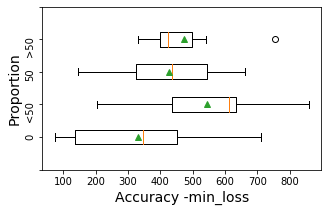

In [139]:
# plt.scatter(index_min_loss_list,byspeed, color=color_list) # byspeed, byproportion
# plt.scatter(acc_at_min_loss_list,byspeed, color=color_list) # byspeed, byproportion

plt.boxplot([list1,list2,list3,list4],vert=False,showmeans=True)  

plt.gcf().set_size_inches(5, 3)


# plt.xlabel('Global Round',fontsize=14) 
plt.xlabel('Accuracy -min_loss',fontsize=14)  
 
# plt.ylabel('Delay Speed',fontsize=14) 
# plt.yticks([0,1,2,3,4,6],['','0','3','12','30',''],rotation=0)

plt.ylabel('Proportion',fontsize=14) 
plt.yticks([0,1,2,3,4,5],['','0','<50','50','>50',''],rotation=90)

patch1 = mpatches.Patch(color='r', label='4k')
patch2 = mpatches.Patch(color='b', label='40k')
# patch3 = mpatches.Patch(color='g', label='10w')
# patch4 = mpatches.Patch(color='m', label='40w')

plt.ylim([0,5])
# plt.legend(handles=[patch1,patch2])


In [37]:
stats.levene(list1,list2,list3,list4)

LeveneResult(statistic=0.22563138651077805, pvalue=0.8776255237669016)

In [38]:
stats.f_oneway(list1,list2,list3,list4)

F_onewayResult(statistic=0.6024080642921759, pvalue=0.6197605528640935)

In [39]:
stats.ttest_rel(list1, list2) 

Ttest_relResult(statistic=0.8847852385961286, pvalue=0.41032449009003585)

In [40]:
stats.ttest_rel(list2, list3) 

Ttest_relResult(statistic=4.5117745482361595, pvalue=0.00405283811024633)

In [41]:
stats.ttest_rel(list3, list4) 

Ttest_relResult(statistic=0.9197202444086395, pvalue=0.39319293807477973)

In [42]:
stats.ttest_rel(list1, list3) 

Ttest_relResult(statistic=3.4272911171933673, pvalue=0.014017694362934905)

In [43]:
stats.ttest_rel(list1, list4) 

Ttest_relResult(statistic=4.295663424761768, pvalue=0.005117021722082537)